In [1]:
import tensorflow as tf
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import shutil

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout#, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.python.keras import utils
from tensorflow.keras.callbacks import TensorBoard

In [3]:
path_to_dataset = '../dataset/N_DATA'

In [4]:
def load_dataset():
    x, y = [], []
    directory = os.fsencode(path_to_dataset)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        pos = filename.find('_')
        label = filename[pos+1:-4]
        data = []
        with open(path_to_dataset+'/'+filename, newline='') as f:
            reader = csv.reader(f, delimiter=';')
            data = [[float(y) for y in x] for x in list(reader)]
        data = np.array(data).T.tolist()
        data.pop(0)
        data.pop(-1)
        x.append(np.array(data).flatten())
        y.append(int(label))
    return np.array(x), np.array(y)

In [5]:
'''
Стандартная загрузка
'''
x, y = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(411, 2807) (137, 2807) (411,) (137,)


In [8]:
# '''
# Удалим первые нули чтобы форма была (400, 7) для сохранения формы после пуллинга
# '''
# x, y = load_dataset()
# x = np.array([point.reshape(401, 7) for point in x])
# x = np.array([point[1:] for point in x])
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
np.unique(y)

array([ 398,  457,  535,  550,  601,  624,  666,  756,  824, 1072, 1126,
       1315, 1336, 1409, 1415, 1416, 1712, 1713, 1715, 1718, 1750, 1763,
       1804, 1817])

In [8]:
def plot_sp(sample):
    plt.figure(figsize=(12, 8))
    plt.grid()
    labels = ['405','458','476','488','496','514','543']
    
    assert len(sample) == 2807
    x = list(range(-200, 201))
    y = np.array(sample).reshape((7, 401))
    
    for label, current_sp in enumerate(y):
        plt.plot(x, current_sp, label=labels[label])
        
    plt.legend()
    plt.show()
    

In [9]:
input_layer = Input(shape=(2807,))

def basic(n_layers, latent_dim, k=2, activation='relu'):
    
    encoded = Dense(n_layers*latent_dim, activation=activation)(input_layer)
    for current_dim in range(n_layers - 1, 0, -1):
        encoded = Dense(current_dim*latent_dim, activation=activation)(encoded)
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation)(encoded)
        for current_dim in range(3, n_layers + 1):
            decoded = Dense(current_dim*latent_dim, activation=activation)(decoded)
        decoded = Dense(2807, activation='sigmoid')(decoded)
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.228273277481397
layers = 1, latent_dim = 32, val_loss = 0.2235166331132253
layers = 1, latent_dim = 64, val_loss = 0.2233111709356308
layers = 1, latent_dim = 128, val_loss = 0.22238944470882416
layers = 1, latent_dim = 256, val_loss = 0.22190323968728384
layers = 1, latent_dim = 512, val_loss = 0.22156224648157755
layers = 1, latent_dim = 1024, val_loss = 0.22146054108937582
layers = 2, latent_dim = 10, val_loss = 0.2253061681985855
layers = 2, latent_dim = 32, val_loss = 0.222817192475001
layers = 2, latent_dim = 64, val_loss = 0.22230293353398642
layers = 2, latent_dim = 128, val_loss = 0.2219502478837967
layers = 2, latent_dim = 256, val_loss = 0.22188882529735565
layers = 2, latent_dim = 512, val_loss = 0.2218087911605835
layers = 2, latent_dim = 1024, val_loss = 0.22183538973331451
layers = 3, latent_dim = 10, val_loss = 0.22482132414976755
layers = 3, latent_dim = 32, val_loss = 0.22282720605532327
layers = 3, latent_dim = 64, val_loss =

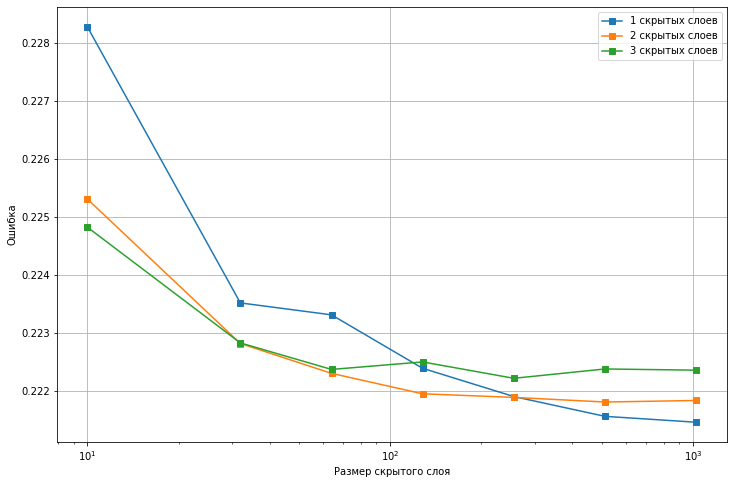

In [10]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = basic(layers, latent_dim)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

Стандартная модель с различным числом слоев и размерностью вектора признаков

2 слоя показывают меньшую ошибку

оптимальное число признаков 128

далее: попытки снизить ошибку

In [13]:
input_layer = Input(shape=(2807,))

def sparse(n_layers, latent_dim, k=2, activation='relu'):
    
    encoded = Dense(n_layers*latent_dim, activation=activation,
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    
    for current_dim in range(n_layers - 1, 0, -1):
        encoded = Dense(current_dim*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(10e-5))(encoded)
        for current_dim in range(3, n_layers + 1):
            decoded = Dense(current_dim*latent_dim, activation=activation,
                            activity_regularizer=regularizers.l1(10e-5))(decoded)
        decoded = Dense(2807, activation='sigmoid')(decoded)
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.2333343873421351
layers = 1, latent_dim = 32, val_loss = 0.22726773718992868
layers = 1, latent_dim = 64, val_loss = 0.22628253698349
layers = 1, latent_dim = 128, val_loss = 0.22585291167100272
layers = 1, latent_dim = 256, val_loss = 0.2252317617336909
layers = 1, latent_dim = 512, val_loss = 0.2248258243004481
layers = 1, latent_dim = 1024, val_loss = 0.22444773217042288
layers = 2, latent_dim = 10, val_loss = 0.23270191252231598
layers = 2, latent_dim = 32, val_loss = 0.22689813375473022
layers = 2, latent_dim = 64, val_loss = 0.22680301467577615
layers = 2, latent_dim = 128, val_loss = 0.22621336579322815
layers = 2, latent_dim = 256, val_loss = 0.22590871155261993
layers = 2, latent_dim = 512, val_loss = 0.22600802779197693
layers = 2, latent_dim = 1024, val_loss = 0.22613151371479034
layers = 3, latent_dim = 10, val_loss = 0.23386819660663605
layers = 3, latent_dim = 32, val_loss = 0.2295302003622055
layers = 3, latent_dim = 64, val_loss

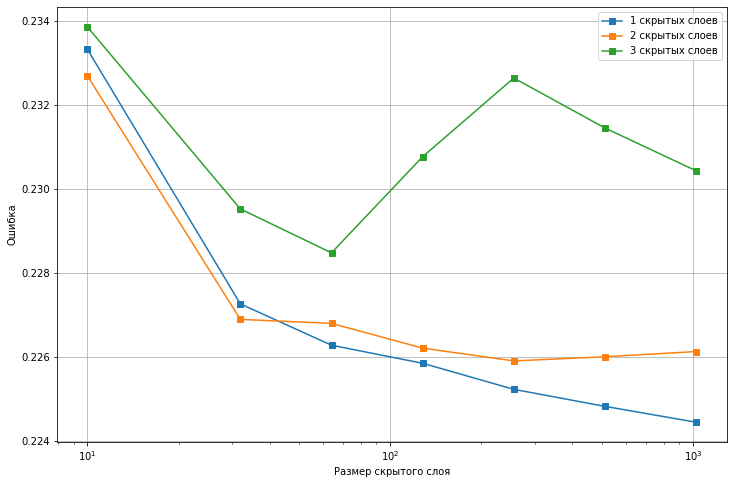

In [14]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = sparse(layers, latent_dim)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

регуляризация на все скрытые слои

2 и 3 слоя увеличили рост ошибки

все ошибки увеличились

-> уменьшим коэфф регуляризации

In [15]:
lambd = 10e-6
input_layer = Input(shape=(2807,))

def sparse(n_layers, latent_dim, k=2, activation='relu'):
    
    encoded = Dense(n_layers*latent_dim, activation=activation,
                    activity_regularizer=regularizers.l1(lambd))(input_layer)
    
    for current_dim in range(n_layers - 1, 0, -1):
        encoded = Dense(current_dim*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(lambd))(encoded)
    
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(lambd))(encoded)
        for current_dim in range(3, n_layers + 1):
            decoded = Dense(current_dim*latent_dim, activation=activation,
                            activity_regularizer=regularizers.l1(lambd))(decoded)
        decoded = Dense(2807, activation='sigmoid')(decoded)
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.2263642152150472
layers = 1, latent_dim = 32, val_loss = 0.2243413875500361
layers = 1, latent_dim = 64, val_loss = 0.22352122763792673
layers = 1, latent_dim = 128, val_loss = 0.22294941544532776
layers = 1, latent_dim = 256, val_loss = 0.22256741921106973
layers = 1, latent_dim = 512, val_loss = 0.2223482479651769
layers = 1, latent_dim = 1024, val_loss = 0.22217356661955515
layers = 2, latent_dim = 10, val_loss = 0.22576884925365448
layers = 2, latent_dim = 32, val_loss = 0.223607008655866
layers = 2, latent_dim = 64, val_loss = 0.22321520745754242
layers = 2, latent_dim = 128, val_loss = 0.22287546594937643
layers = 2, latent_dim = 256, val_loss = 0.22305581470330557
layers = 2, latent_dim = 512, val_loss = 0.2229366401831309
layers = 2, latent_dim = 1024, val_loss = 0.22299636900424957
layers = 3, latent_dim = 10, val_loss = 0.2260778248310089
layers = 3, latent_dim = 32, val_loss = 0.2239593913157781
layers = 3, latent_dim = 64, val_loss 

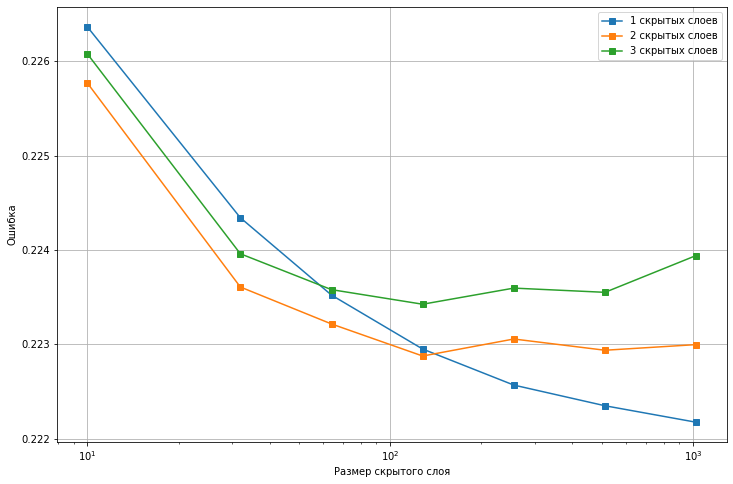

In [16]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = sparse(layers, latent_dim)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

стало лучше, но все ошибки все еще выше чем без регуляризации

сам факт внесения р-ии увеличивает ошибку -> пропадают важные признаки

уберем регуляризацию с первого скрытого слоя

In [17]:
lambd = 10e-6
input_layer = Input(shape=(2807,))

def sparse(n_layers, latent_dim, k=2, activation='relu'):
    
    encoded = Dense(n_layers*latent_dim, activation=activation)(input_layer)
    
    for current_dim in range(n_layers - 1, 0, -1):
        encoded = Dense(current_dim*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(lambd))(encoded)
    
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(lambd))(encoded)
        for current_dim in range(3, n_layers + 1):
            if current_dim == n_layers:
                decoded = Dense(current_dim*latent_dim, activation=activation)(decoded)
            else:
                decoded = Dense(current_dim*latent_dim, activation=activation,
                                activity_regularizer=regularizers.l1(lambd))(decoded)
                
        decoded = Dense(2807, activation='sigmoid')(decoded)
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.22638647258281708
layers = 1, latent_dim = 32, val_loss = 0.22354693710803986
layers = 1, latent_dim = 64, val_loss = 0.2229569802681605
layers = 1, latent_dim = 128, val_loss = 0.22236150999863943
layers = 1, latent_dim = 256, val_loss = 0.22199855744838715
layers = 1, latent_dim = 512, val_loss = 0.22156210243701935
layers = 1, latent_dim = 1024, val_loss = 0.22143120567003885
layers = 2, latent_dim = 10, val_loss = 0.2263051321109136
layers = 2, latent_dim = 32, val_loss = 0.22333532075087228
layers = 2, latent_dim = 64, val_loss = 0.2230087866385778
layers = 2, latent_dim = 128, val_loss = 0.22265724341074625
layers = 2, latent_dim = 256, val_loss = 0.22260388731956482
layers = 2, latent_dim = 512, val_loss = 0.2226929316918055
layers = 2, latent_dim = 1024, val_loss = 0.22278996805349985
layers = 3, latent_dim = 10, val_loss = 0.22627021869023642
layers = 3, latent_dim = 32, val_loss = 0.22324949502944946
layers = 3, latent_dim = 64, val_l

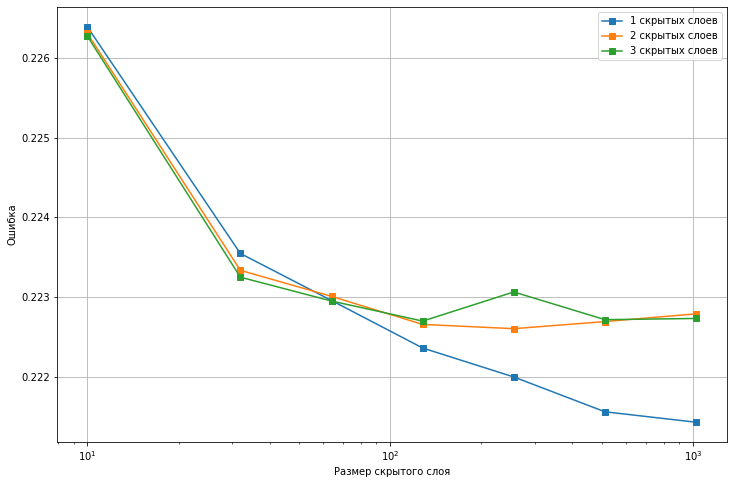

In [18]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = sparse(layers, latent_dim)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

ошибки снизились, но все еще недостаточно

применим регуляризацию только к последнему слою энкодера, увеличим число эпох

In [19]:
lambd = 10e-6
input_layer = Input(shape=(2807,))

def sparse(n_layers, latent_dim, k=2, activation='relu'):
    
    if n_layers == 1:
        encoded = Dense(n_layers*latent_dim, activation=activation,
                        activity_regularizer=regularizers.l1(lambd))(input_layer)
    else:
        encoded = Dense(n_layers*latent_dim, activation=activation)(input_layer)
    
    for current_dim in range(n_layers - 1, 0, -1):
        if current_dim == 1:
            encoded = Dense(current_dim*latent_dim, activation=activation,
                            activity_regularizer=regularizers.l1(lambd))(encoded)
        else:
            encoded = Dense(current_dim*latent_dim, activation=activation)(encoded)
        
    
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation)(encoded)
    
        for current_dim in range(3, n_layers + 1):
            decoded = Dense(current_dim*latent_dim, activation=activation)(decoded)
            
        decoded = Dense(2807, activation='sigmoid')(decoded)
        
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.22582892576853433
layers = 1, latent_dim = 32, val_loss = 0.2243597557147344
layers = 1, latent_dim = 64, val_loss = 0.22352095444997153
layers = 1, latent_dim = 128, val_loss = 0.22297842303911844
layers = 1, latent_dim = 256, val_loss = 0.22255896031856537
layers = 1, latent_dim = 512, val_loss = 0.2222967892885208
layers = 1, latent_dim = 1024, val_loss = 0.22216654320557913
layers = 2, latent_dim = 10, val_loss = 0.2247971147298813
layers = 2, latent_dim = 32, val_loss = 0.22321405510107675
layers = 2, latent_dim = 64, val_loss = 0.22265472014745077
layers = 2, latent_dim = 128, val_loss = 0.22226180136203766
layers = 2, latent_dim = 256, val_loss = 0.22212115426858267
layers = 2, latent_dim = 512, val_loss = 0.2222895622253418
layers = 2, latent_dim = 1024, val_loss = 0.2221685548623403
layers = 3, latent_dim = 10, val_loss = 0.2255892207225164
layers = 3, latent_dim = 32, val_loss = 0.2230391800403595
layers = 3, latent_dim = 64, val_loss

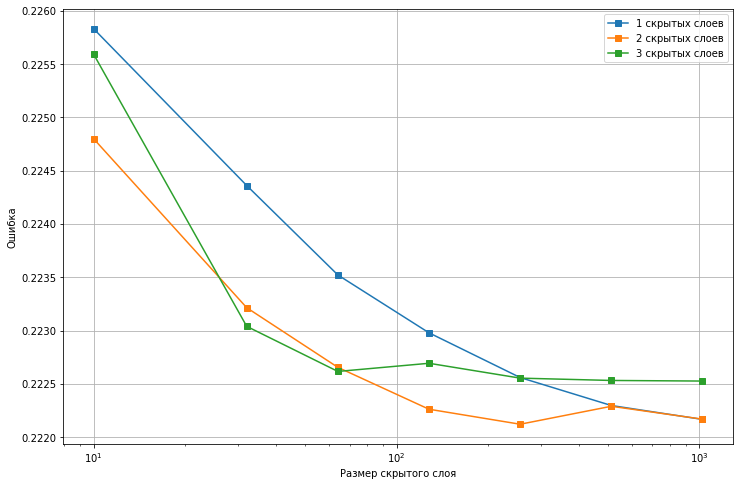

In [20]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = sparse(layers, latent_dim)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

ошибки незначительно выше

выводы
- регуляризация не помогла 
  - много признаков близких к нулю, из которых декодер восстанавливает исходный спектр
  - маленький датасет
- оптимально 2 слоя с размером 64, 128
- 1 слой на 512 дает меньшую ошибку

попробовать denoising 

для 64 и 128 попробовать разный коэффициент увеличения нейронов от слоя к слою

для 128 попробовать изменить функцию активации на elu со ссылкой на проблему relu

In [22]:
input_layer = Input(shape=(2807,))

def model_k(n_layers, latent_dim, k=2, activation='relu'):
    
    encoded = Dense(k*latent_dim, activation=activation)(input_layer)
    encoded = Dense(latent_dim, activation=activation)(encoded)
    
    
    
    decoded = Dense(k*latent_dim, activation=activation)(encoded)
    decoded = Dense(2807, activation=activation)(decoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

1/5	2/5	3/5	4/5	5/5	
k = 1.0 loss = 0.2954610824584961
1/5	2/5	3/5	4/5	5/5	
k = 1.1 loss = 0.32007575035095215
1/5	2/5	3/5	4/5	5/5	
k = 1.2 loss = 0.3166914820671082
1/5	2/5	3/5	4/5	5/5	
k = 1.3 loss = 0.30003308653831484
1/5	2/5	3/5	4/5	5/5	
k = 1.4 loss = 0.29423832297325136
1/5	2/5	3/5	4/5	5/5	
k = 1.5 loss = 0.27672969698905947
1/5	2/5	3/5	4/5	5/5	
k = 1.6 loss = 0.2782145798206329
1/5	2/5	3/5	4/5	5/5	
k = 1.7 loss = 0.2798828065395355
1/5	2/5	3/5	4/5	5/5	
k = 1.8 loss = 0.28867332339286805
1/5	2/5	3/5	4/5	5/5	
k = 1.9 loss = 0.268473356962204
1/5	2/5	3/5	4/5	5/5	
k = 2.0 loss = 0.2715902328491211


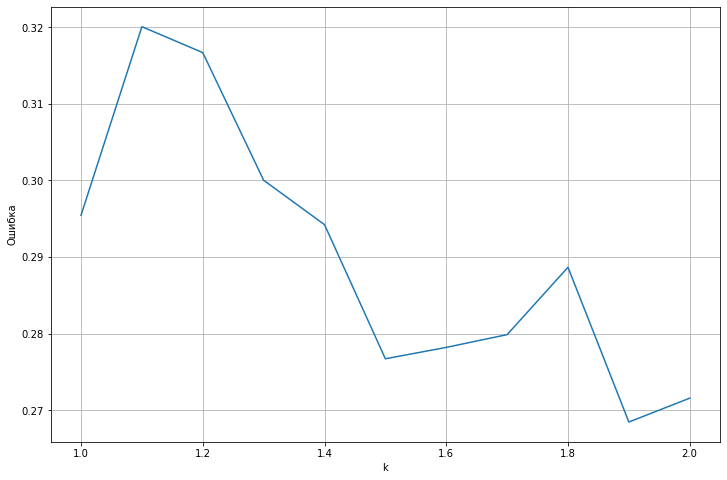

In [25]:
k_64_losses = []
k_values = np.arange(1,2.1,0.1)
for k in k_values:
    errors = []
    for i in range(5):
        tf.keras.backend.clear_session()
        model = model_k(2, 64, k=k)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        history = model.fit(x_train, x_train,
                            epochs=90,
                            batch_size=16,
                            shuffle=True,
                            verbose=0,
                            validation_data=(x_test, x_test))
        errors.append(history.history['val_loss'][-1])
        print(f'{i+1}/5', end='\t')
    print()
    k_64_losses.append(np.sum(errors) / 5)
    print(f'k = {np.round(k, 1)} loss = {k_64_losses[-1]}')

plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('k')
plt.ylabel('Ошибка')
plt.plot(k_values, k_64_losses)

1/5	2/5	3/5	4/5	5/5	
k = 1.0 loss = 0.27697463035583497
1/5	2/5	3/5	4/5	5/5	
k = 1.1 loss = 0.26742547154426577
1/5	2/5	3/5	4/5	5/5	
k = 1.2 loss = 0.2602418512105942
1/5	2/5	3/5	4/5	5/5	
k = 1.3 loss = 0.2627619683742523
1/5	2/5	3/5	4/5	5/5	
k = 1.4 loss = 0.2539825737476349
1/5	2/5	3/5	4/5	5/5	
k = 1.5 loss = 0.24654277861118318
1/5	2/5	3/5	4/5	5/5	
k = 1.6 loss = 0.24594780504703523
1/5	2/5	3/5	4/5	5/5	
k = 1.7 loss = 0.24595329463481902
1/5	2/5	3/5	4/5	5/5	
k = 1.8 loss = 0.25374121963977814
1/5	2/5	3/5	4/5	5/5	
k = 1.9 loss = 0.2489104300737381
1/5	2/5	3/5	4/5	5/5	
k = 2.0 loss = 0.24357417225837708


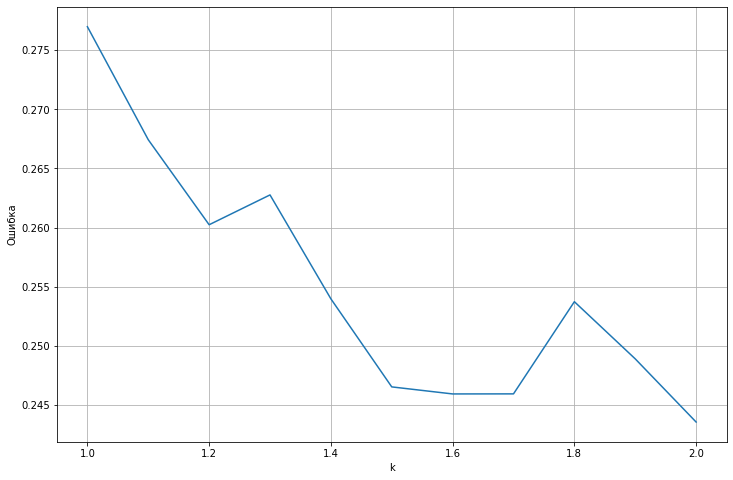

In [26]:
k_128_losses = []
k_values = np.arange(1,2.1,0.1)
for k in k_values:
    errors = []
    for i in range(5):
        tf.keras.backend.clear_session()
        model = model_k(2, 128, k=k)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        history = model.fit(x_train, x_train,
                            epochs=90,
                            batch_size=16,
                            shuffle=True,
                            verbose=0,
                            validation_data=(x_test, x_test))
        errors.append(history.history['val_loss'][-1])
        print(f'{i+1}/5', end='\t')
    print()
    k_128_losses.append(np.sum(errors) / 5)
    print(f'k = {np.round(k, 1)} loss = {k_128_losses[-1]}')

plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('k')
plt.ylabel('Ошибка')
plt.plot(k_values, k_128_losses)

на 60% увеличивать число нейронов эффективнее всего

теперь попробуем elu для трех слоев

In [29]:
input_layer = Input(shape=(2807,))

def basic(n_layers, latent_dim, k=2, activation='relu'):
    encoded = Dense(n_layers*latent_dim, activation=activation)(input_layer)
    for current_dim in range(n_layers - 1, 0, -1):
        encoded = Dense(current_dim*latent_dim, activation=activation)(encoded)
    
    if n_layers > 1:
        decoded = Dense(2*latent_dim, activation=activation)(encoded)
        for current_dim in range(3, n_layers + 1):
            decoded = Dense(current_dim*latent_dim, activation=activation)(decoded)
        decoded = Dense(2807, activation='sigmoid')(decoded)
    else:
         decoded = Dense(2807, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    
    return autoencoder

layers = 1, latent_dim = 10, val_loss = 0.2315258284409841
layers = 1, latent_dim = 32, val_loss = 0.2239218751589457
layers = 1, latent_dim = 64, val_loss = 0.22299603124459585
layers = 1, latent_dim = 128, val_loss = 0.22248846292495728
layers = 1, latent_dim = 256, val_loss = 0.2219284176826477
layers = 1, latent_dim = 512, val_loss = 0.22157863279183707
layers = 1, latent_dim = 1024, val_loss = 0.22138522565364838
layers = 2, latent_dim = 10, val_loss = 0.22763063510258993
layers = 2, latent_dim = 32, val_loss = 0.222723717490832
layers = 2, latent_dim = 64, val_loss = 0.22233833372592926
layers = 2, latent_dim = 128, val_loss = 0.22205927471319833
layers = 2, latent_dim = 256, val_loss = 0.2218379726012548
layers = 2, latent_dim = 512, val_loss = 0.2219159652789434
layers = 2, latent_dim = 1024, val_loss = 0.22182165582974753
layers = 3, latent_dim = 10, val_loss = 0.22399848699569702
layers = 3, latent_dim = 32, val_loss = 0.2224595993757248
layers = 3, latent_dim = 64, val_loss 

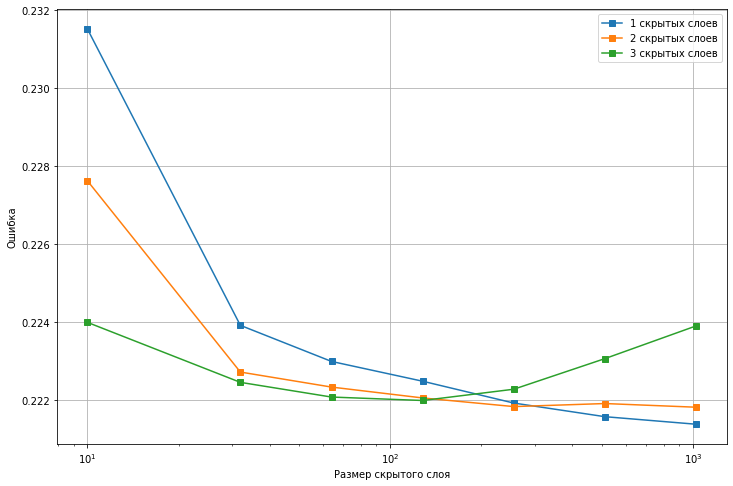

In [30]:
latent_dims = [10, 32, 64, 128, 256, 512, 1024]
plt.figure(figsize=(12, 8))
plt.grid()
plt.xscale('log')
plt.xlabel('Размер скрытого слоя')
plt.ylabel('Ошибка')

for layers in range(1, 4):
    losses = []
    for latent_dim in latent_dims:
        errors = []
        for i in range(3):
            tf.keras.backend.clear_session()
            autoencoder = basic(layers, latent_dim, activation='relu' if layers != 3 else 'elu')
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            history = autoencoder.fit(x_train, x_train,
                        epochs=90,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
            errors.append(history.history['val_loss'][-1])
        error = np.sum(errors) / 3
        losses.append(error)
        print(f'''layers = {layers}, latent_dim = {latent_dim}, val_loss = {error}''')
    plt.plot(latent_dims, losses, 's-', label=f'{layers} скрытых слоев')

plt.legend()
plt.show()

elu незначительно снизило ошибку для одних значений и понизила для других

пробуем denoising

In [34]:
def dropout_model(dropout_rate):
    input_layer = Input(shape=(2807,))
    encoded = Dropout(dropout_rate)(input_layer)

    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(2807, activation='sigmoid')(decoded)

    model = Model(input_layer, decoded)
    return model

In [35]:
drop_losses = []
for dropout_rate in np.arange(0.0,1.0,0.05):
    errors = []
    for i in range(10):
        tf.keras.backend.clear_session()
        model = dropout_model(dropout_rate)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        history = autoencoder.fit(x_train, x_train,
                            epochs=90,
                            batch_size=16,
                            shuffle=True,
                            verbose=0,
                            validation_data=(x_test, x_test))
        errors.append(history.history['val_loss'][-1])
        print(f'{i+1}/10', end='\t')
    print()
    drop_losses.append(np.sum(errors) / 10)
    print(f'drop_rate = {dropout_rate} loss = {drop_losses[-1]}')

1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.0 loss = 0.22370302081108093
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.05 loss = 0.22363811284303664
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.1 loss = 0.2237742140889168
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.15000000000000002 loss = 0.22373543828725814
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.2 loss = 0.22377169132232666
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.25 loss = 0.2238013669848442
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.30000000000000004 loss = 0.22383603304624558
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.35000000000000003 loss = 0.2237495571374893
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.4 loss = 0.22367588430643082
1/10	2/10	3/10	4/10	5/10	6/10	7/10	8/10	9/10	10/10	
drop_rate = 0.45 loss = 0.22397181689739226
1/

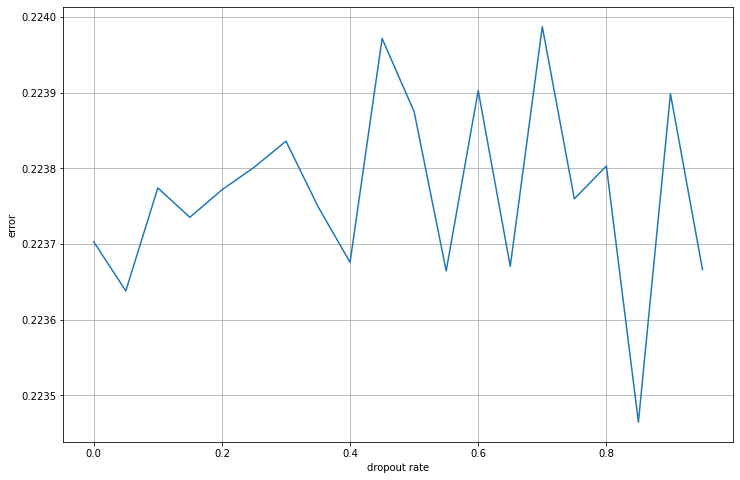

In [37]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('dropout rate')
plt.ylabel('error')
plt.plot(np.arange(0.0,1.0,0.05), drop_losses)

In [39]:
np.mean(drop_losses[1:])

0.22377092501050547

In [65]:
sample = np.array(x_train[20]).reshape(((1, 2807)))
prediction = autoencoder(sample, training=False).numpy().flatten()

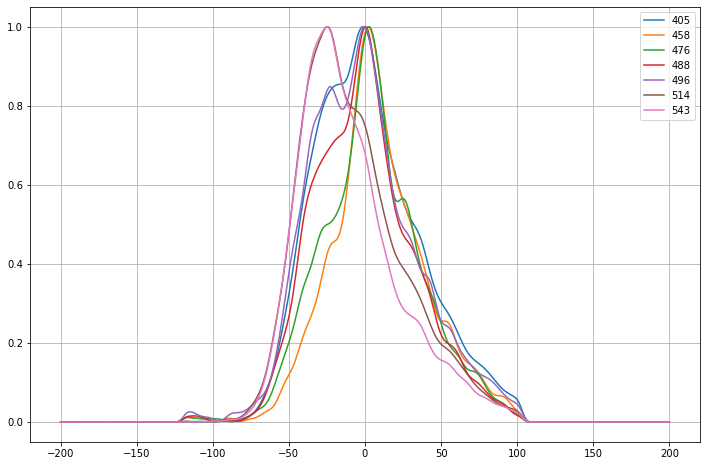

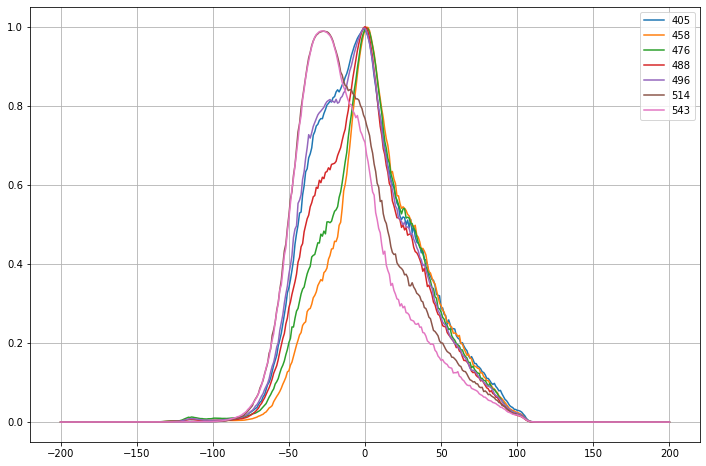

In [66]:
plot_sp(x_train[20])
plot_sp(prediction)

In [52]:
history.history['val_loss'][-1]

0.22742223739624023